## Cats and Dogs (1/3)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Este é o primeiro de 3 experimentos que ilustram a importância da transferência de conhecimento (*transfer learning*), isto é, utilizar pesos de redes já treinadas em outras aplicações.

Utiliza-se aqui uma rede convolucional com mais de 1 milhão de parâmetros a serem treinados. O treinamento é feito de uma rede com inicialização padrão do Keras.

Este notebook ilustra também a técnica de *data augmentation*.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models', exist_ok=True)

Keras  2.0.4


In [12]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    CatsDogs/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

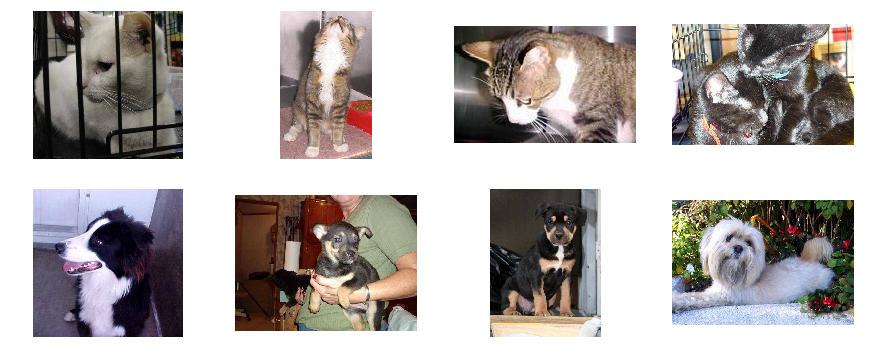

In [13]:
train_data_dir = '../../datasets/CatsDogs/train'
validation_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

N = 4
image_filenames = []
fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, N)):  # mostrando N gatos e N cachorros de forma aleatória
    fig.add_subplot(2, N, i+1)
    fn = '{}/cats/cat.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)
    plot.axis('off')
    image_filenames.append(fn)
    
    fig.add_subplot(2, N, i+N+1)
    fn = '{}/dogs/dog.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)    
    plot.axis('off')
    image_filenames.append(fn)



## Aumentando o dataset


In [14]:
# dimensions of our images.
img_width, img_height = 150, 150

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
       rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

# train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

Mostrando o funcionamento do ImageDataGenerator para 8 imagens, 4 cachorros e 4 gatos

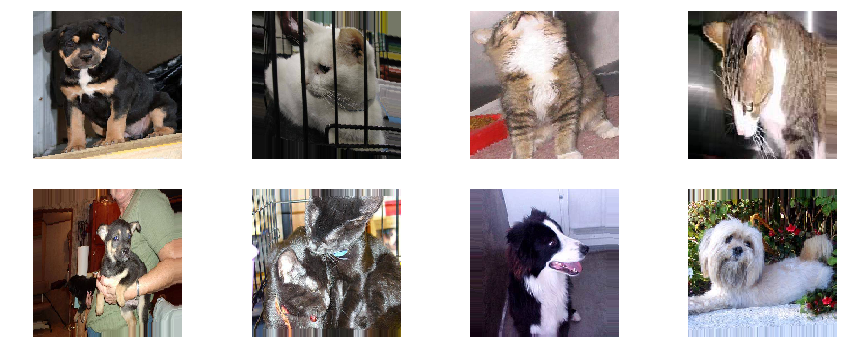

In [15]:
X_s = np.empty((2*N, 150, 150, 3), np.uint8)
y_s = np.empty((2*N,), np.int32)
for i, fn in enumerate(image_filenames):
    y_s[i] = 1 if fn.split('/')[-2] == 'dogs' else 0
    img = load_img(fn, grayscale=False, target_size=(150, 150))
    X_s[i] = img_to_array(img, data_format=image_format)

# Criação do generator
generator = train_datagen.flow(X_s, y_s, batch_size=8)  # 

X, y = generator.next()

fig = plot.figure(figsize=(15,6))
for i, img in enumerate(X):
    fig.add_subplot(2, 4, i+1)
    plot.imshow(img)
    plot.axis('off')
    

In [16]:
batch_size = 40

train_generator = train_datagen.flow_from_directory(
        train_data_dir,                       # as amostras de treinamento
        target_size=(img_width, img_height),
        batch_size=batch_size,                # batch size do SGD
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,                  # as amostras de validação
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Classificador
A rede neural utilizada é especificada a seguir.

In [17]:
class LeNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Convolution2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
#         model.add(BatchNormalization(axis=-1))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Convolution2D(32, (3, 3)))
#         model.add(BatchNormalization(axis=-1))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Convolution2D(64, (3, 3)))
#         model.add(BatchNormalization(axis=-1))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
#         model.add(BatchNormalization(axis=-1))
        model.add(Activation('relu'))

        model.add(Dropout(0.5))

        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        return model

# LeNet.build(img_width, img_height).summary()

In [18]:
model_name = '../../models/cats_dogs_bn_1'
os.unlink(model_name + '.model')

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    # lr decay: lr /= (1 + decay * iter)
    opt = SGD(lr=0.1, momentum=0.9, decay=0.001, nesterov=True)
    opt = SGD(lr=0.1, momentum=0.9, nesterov=True)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)


[INFO] creating model...
[INFO] compiling model...


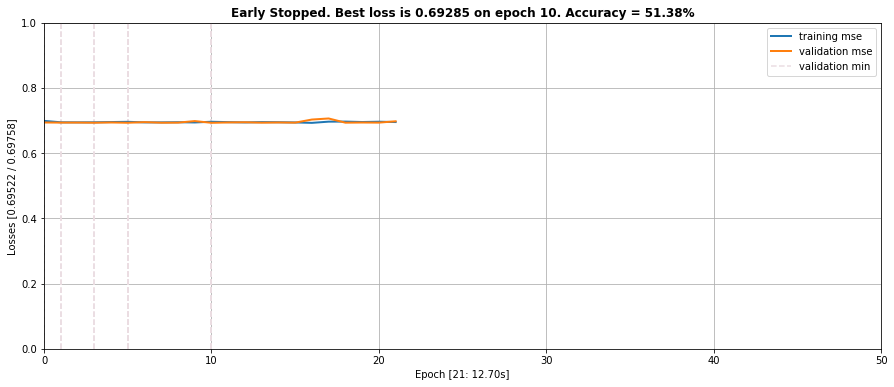

In [19]:
nb_epoch = 50
ploss = 1.0

train_steps = nb_train_samples / batch_size
valid_steps = nb_validation_samples / batch_size

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        model.fit_generator(
            train_generator,                          # gerador de amostras de treinamento
            steps_per_epoch=train_steps,              # tamanho para a época (tamanho total do dataset)
            epochs=nepochs,
            validation_data=validation_generator,
            validation_steps=valid_steps,
            verbose=0,
            callbacks=[histo],
        )
    except KeyboardInterrupt:
        pass
else:
    print("[INFO] plotting...")
    

In [10]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name)
print('       from epoch {}'.format(histo.best_epoch))
print("[INFO] evaluating...")
loss, accuracy = model.evaluate_generator(validation_generator, valid_steps)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] loading model...
       from epoch 6
[INFO] evaluating...
[INFO] accuracy: 50.88%
